In [3]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.core.problem import DaskParallelization

from dask.distributed import Client

In [4]:
client = Client()
client.restart()
print("DASK STARTED")

2022-10-08 22:04:03,459 - distributed.worker - WARNING - Mismatched versions found

+---------+---------------------------------------------+-----------+---------+
| Package | Worker-cfa09e89-7afb-4470-8d59-b62254768e80 | Scheduler | Workers |
+---------+---------------------------------------------+-----------+---------+
| tornado | 6.1                                         | 6.2       | 6.1     |
+---------+---------------------------------------------+-----------+---------+
2022-10-08 22:04:03,574 - distributed.worker - WARNING - Mismatched versions found

+---------+---------------------------------------------+-----------+---------+
| Package | Worker-997d32bc-a3eb-45f6-ae66-ef5cb0c16f00 | Scheduler | Workers |
+---------+---------------------------------------------+-----------+---------+
| tornado | 6.1                                         | 6.2       | 6.1     |
+---------+---------------------------------------------+-----------+---------+
2022-10-08 22:04:03,629 - distri

DASK STARTED


2022-10-08 22:04:05,630 - distributed.worker - WARNING - Mismatched versions found

+---------+---------------------------------------------+-----------+---------+
| Package | Worker-e77d3830-ff4f-413b-92e4-ad6eb0223ac6 | Scheduler | Workers |
+---------+---------------------------------------------+-----------+---------+
| tornado | 6.1                                         | 6.2       | 6.1     |
+---------+---------------------------------------------+-----------+---------+


In [5]:
# 首先定义一个问题 MyProblem()
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    def __init__(self, **kwargs):
        super().__init__(n_var=10, n_obj=1, n_ieq_constr=0, xl=-5, xu=5, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = (x ** 2).sum()

In [6]:
# initialize the thread pool and create the runner
runner = DaskParallelization(client)

# Define the problem by passing the starmap interface of the thread pool
problem = MyProblem(elementwise_runner=runner)

res = minimize(problem, GA(), termination=("n_gen", 200))
print('Threads', res.exec_time)

client.close()
print("DASK SHUTDOWN")

Threads 170.6758279800415
DASK SHUTDOWN


In [7]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize

problem = get_problem("zdt1")

algorithm = NSGA2(pop_size=100)

res = minimize(
  problem, 
  algorithm,
  ('n_gen', 10),
  verbose=True
)

# calculate a has to show that all executions end with the same result
print("hash", res.F.sum())

n_gen  |  n_eval  | n_nds  |      igd      |       gd      |       hv     
     1 |      100 |     10 |  2.2233246661 |  3.1136634111 |  0.000000E+00
     2 |      200 |      5 |  1.6685913198 |  2.2069411487 |  0.000000E+00
     3 |      300 |      7 |  1.6685913198 |  2.0826323626 |  0.000000E+00
     4 |      400 |     11 |  1.4328333780 |  1.8080803255 |  0.000000E+00
     5 |      500 |      7 |  1.1582272363 |  1.8564722989 |  0.000000E+00
     6 |      600 |     12 |  0.9544683307 |  1.5490110214 |  0.000000E+00
     7 |      700 |     14 |  0.8074330851 |  1.2982068452 |  0.000000E+00
     8 |      800 |      8 |  0.6280259615 |  1.0327221507 |  0.0398424618
     9 |      900 |      9 |  0.5354784690 |  0.8270071826 |  0.0814193540
    10 |     1000 |     12 |  0.4899094254 |  0.7779276021 |  0.1390098883
hash 21.416564564906547


In [1]:
import datetime

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem

problem = get_problem("zdt1")

algorithm = NSGA2(pop_size=100)

# prepare the algorithm to solve the specific probem (same arguments as for the minimize function)
# 准备解决特定问题的算法（比如 minimize 函数的参数）
algorithm.setup(problem, termination=('n_gen', 10), verbose=False)

# until the algorithm has no terminated
# 直到算法没有终止
while algorithm.has_next():
  # do the next iteration
  algorithm.next()
  
  # do same more things, printing, logging, storing or even modifying the algorithm object
  print(algorithm.n_gen, algorithm.evaluator.n_eval)
  
# obtain the result objective from the algorithm
# 得到算法的计算结果
res = algorithm.result()

# calculate a hash to show that all executions end with the same result
print("hash", res.F.sum())

2 100
3 200
4 300
5 400
6 500
7 600
8 700
9 800
10 900
11 1000
hash 27.187881024324287


In [2]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem

problem = get_problem("zdt1")

algorithm = NSGA2(pop_size=100)

# prepare the algorithm to solve the specific problem (same as for minimize function)
# 准备解决特定问题的算法（与 minimize 函数准备过程一样）
algorithm.setup(problem, termination=("n_gen", 10), verbose=False)

# until the algorithm has no terminated
# 直到算法没有终止
while algorithm.has_next():
  # ask the algorithm for the next solution to be evaluated
  # 询问算法下一个需要求解的解
  pop = algorithm.ask()
  
  # evaluate the individuals using the algorithm's evaluator (necessary to count evaluations for termination)
  # 使用算法的求解器 (evaluator) 求解个体 
  algorithm.evaluator.eval(problem, pop)
  
  # return the evaluated individuals which have been evaluated or even modified
  # 返回求解的个体
  algorithm.tell(infills=pop)
  
  # do same more things, printing, logging, storing or even modifying the algorithm object
  print(algorithm.n_gen, algorithm.evaluator.n_eval)
  
# obtain the result objective from the algorithm
# 从 algorithm 对象中获得计算对象
res = algorithm.result()

# calculate a hash to show that all executions end with the same result
print("hash", res.F.sum())

2 100
3 200
4 300
5 400
6 500
7 600
8 700
9 800
10 900
11 1000
hash 24.924250393334695


In [1]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.termination import get_termination
from pymoo.optimize import minimize

problem = get_problem("zdt3")
algorithm = NSGA2(pop_size=100)
termination = get_termination("n_gen", 10)

res = minimize(
  problem,
  algorithm,
  termination,
  pf=problem.pareto_front(),
  verbose=True
)

n_gen  |  n_eval  | n_nds  |      igd      |       gd      |       hv     
     1 |      100 |     12 |  1.3608040575 |  1.5403672519 |  0.000000E+00
     2 |      200 |     11 |  0.9883720003 |  1.3651771590 |  0.000000E+00
     3 |      300 |      9 |  0.9611285926 |  1.3683309644 |  0.000000E+00
     4 |      400 |     15 |  0.9611285926 |  1.2939905748 |  0.000000E+00
     5 |      500 |     10 |  0.7486451942 |  0.8875554075 |  0.0020208450
     6 |      600 |     13 |  0.6937968443 |  0.8396369920 |  0.0020208450
     7 |      700 |     15 |  0.5233985753 |  0.8062816611 |  0.0067999269
     8 |      800 |     16 |  0.4560396286 |  0.8320200659 |  0.0460851889
     9 |      900 |     17 |  0.4256293915 |  0.5826932157 |  0.0677481428
    10 |     1000 |     19 |  0.3723238251 |  0.5592201783 |  0.1214415889


Generations 104


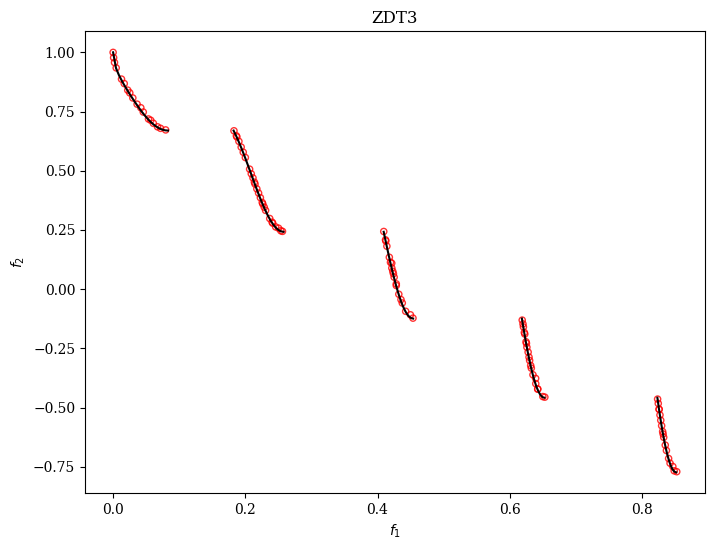

In [4]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.termination.ftol import MultiObjectiveSpaceTermination
from pymoo.visualization.scatter import Scatter
from pymoo.termination.robust import RobustTermination

problem = get_problem("zdt3")

algorithm = NSGA2(pop_size=100)

termination = RobustTermination(
  MultiObjectiveSpaceTermination(tol=0.005,n_skip=5),
  period=20
)

res = minimize(
  problem,
  algorithm,
  termination,
  pf=True,
  verbose=False
)

print("Generations", res.algorithm.n_gen)
plot = Scatter(title="ZDT3")
plot.add(problem.pareto_front(
  use_cache=False,
  flatten=False,
), plot_type="line", color="black")
plot.add(res.F, facecolor="none", edgecolor="red", alpha=0.8, s=20)
plot.show()

In [5]:
import numpy as np

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.util.display.column import Column
from pymoo.util.display.output import Output

class MyOutput(Output):
  
  def __init__(self):
    super().__init__()
    self.x_mean = Column("x_mean, width=13")
    self.x_std = Column("x_std", width=13)
    self.columns += [self.x_mean, self.x_std]
    
  def update(self, algorithm):
    super().update(algorithm)
    self.x_mean.set(np.mean(algorithm.pop.get("X")))
    self.x_std.set(np.std(algorithm.pop.get("X")))
    
problem = get_problem("zdt2")

algorithm = NSGA2(pop_size=100)

res = minimize(
  problem,
  algorithm,
  ('n_gen', 10),
  output=MyOutput(),
  verbose=True
)

n_gen  |  n_eval  | x_mean, width=13 |     x_std    
     1 |      100 |  0.4925522065 |  0.2888478357
     2 |      200 |  0.4468434921 |  0.2848676096
     3 |      300 |  0.4073266279 |  0.2793257262
     4 |      400 |  0.3676846172 |  0.2736868492
     5 |      500 |  0.3288802411 |  0.2634771809
     6 |      600 |  0.2744002591 |  0.2384865056
     7 |      700 |  0.2467990580 |  0.2276834923
     8 |      800 |  0.2029468071 |  0.1989383050
     9 |      900 |  0.1716710394 |  0.1771165440
    10 |     1000 |  0.1503598326 |  0.1669816817


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  0.8479723275 |  0.3219020194
     2 |      200 |  0.6258097857 |  0.3219020194
     3 |      300 |  0.5071779582 |  0.2120419518
     4 |      400 |  0.3883498669 |  0.1806769200
     5 |      500 |  0.2909969476 |  0.1585534222
     6 |      600 |  0.2251224522 |  0.1300497156
     7 |      700 |  0.1786760660 |  0.0693289643
     8 |      800 |  0.1427740224 |  0.0673424986
     9 |      900 |  0.1099581015 |  0.0615825179
    10 |     1000 |  0.0846906484 |  0.0234646270
    11 |     1100 |  0.0651651319 |  0.0177964449
    12 |     1200 |  0.0482783572 |  0.0094690281
    13 |     1300 |  0.0326309568 |  0.0094690281
    14 |     1400 |  0.0218679009 |  0.0064910359
    15 |     1500 |  0.0158414390 |  0.0042116300
    16 |     1600 |  0.0114440080 |  0.0042116300
    17 |     1700 |  0.0085573940 |  0.0039818470
    18 |     1800 |  0.0067914496 |  0.0017333331
    19 |     1900 |  0.0051500895 |  0.0017333331


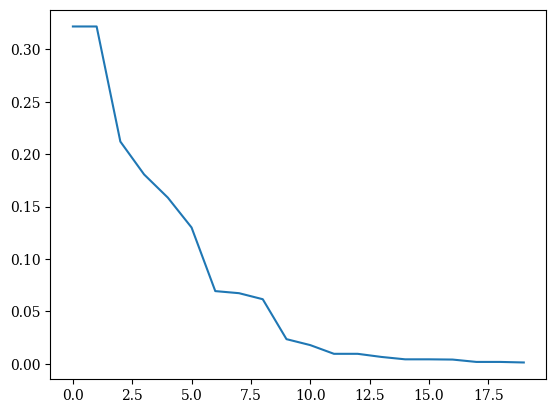

In [7]:
import matplotlib.pyplot as plt
import numpy as np

from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.problems import get_problem
from pymoo.core.callback import Callback
from pymoo.optimize import minimize

class MyCallback(Callback):
  
  def __init__(self) -> None:
    super().__init__()
    self.data["best"] = []
    
  def notify(self, algorithm):
    self.data["best"].append(algorithm.pop.get("F").min())
    
problem = get_problem("sphere")

algorithm = GA(pop_size=100)

res = minimize(
  problem,
  algorithm,
  ('n_gen', 20),
  callback=MyCallback(),
  verbose=True
)

val = res.algorithm.callback.data["best"]
plt.plot(np.arange(len(val)), val)
plt.show()

In [8]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.problems import get_problem
from pymoo.optimize import minimize


problem = get_problem("sphere")
algorithm = GA(pop_size=5)
res = minimize(problem,
               algorithm,
               ('n_gen', 30),)

In [10]:
res.pop.get("X")

array([[0.48518266, 0.437361  , 0.44069713, 0.65420212, 0.49613196,
        0.62033332, 0.50218401, 0.60701128, 0.4849062 , 0.62399976],
       [0.48518266, 0.437361  , 0.33412771, 0.58113342, 0.49613196,
        0.62033332, 0.50218401, 0.60701128, 0.4849062 , 0.62399976],
       [0.48518266, 0.437361  , 0.33407064, 0.58113342, 0.49613196,
        0.61863938, 0.46644193, 0.60701128, 0.42496975, 0.62399976],
       [0.50844141, 0.437361  , 0.38845526, 0.6778921 , 0.49613196,
        0.62037311, 0.50061862, 0.60701128, 0.48541657, 0.62399976],
       [0.48518266, 0.360095  , 0.31307427, 0.57661289, 0.49613196,
        0.61867674, 0.47381354, 0.60701128, 0.48322636, 0.62399976]])

In [11]:
res.pop.get("F")

array([[0.07299334],
       [0.07979446],
       [0.08593168],
       [0.08962779],
       [0.1024973 ]])

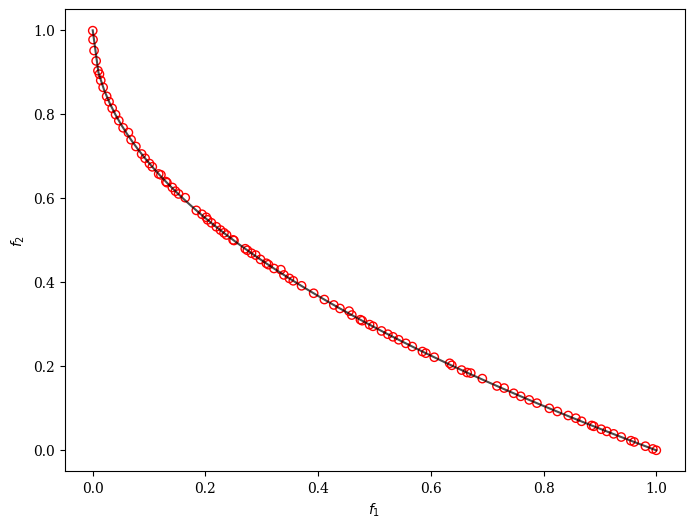

In [12]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("zdt1")

algorithm = NSGA2(pop_size=100)

res = minimize(
  problem,
  algorithm,
  ('n_gen', 200),
  verbose=False
)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

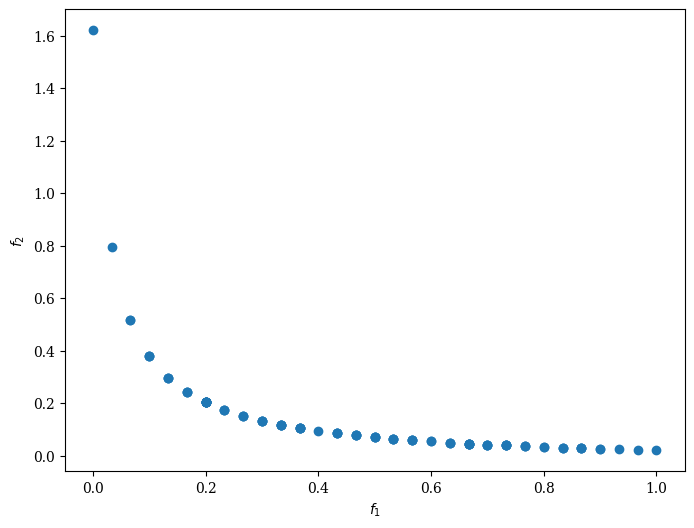

In [13]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("zdt5")

algorithm = NSGA2(
  pop_size=100,
  sampling=BinaryRandomSampling(),
  crossover=TwoPointCrossover(),
  mutation=BitflipMutation(),
  eliminate_duplicates=True
)

res = minimize(
  problem,
  algorithm,
  ('n_gen', 500),
  verbose=False
)

Scatter().add(res.F).show()

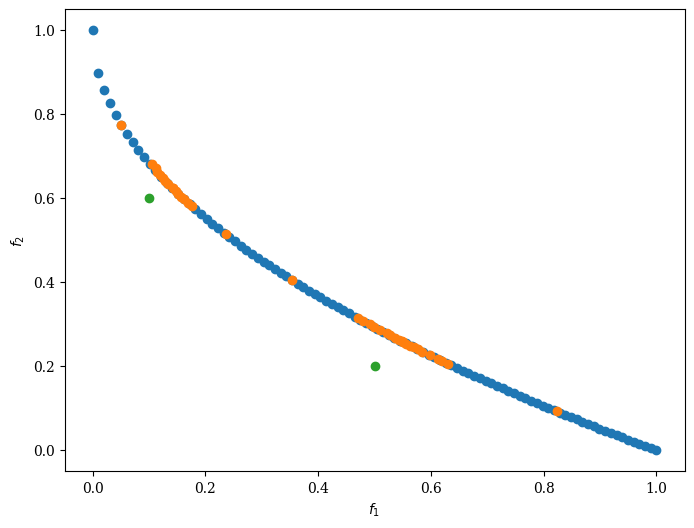

In [14]:
import numpy as np

from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("zdt1", n_var=30)
pf = problem.pareto_front()

# 定义参考点
ref_points = np.array([[0.5, 0.2], [0.1, 0.6]])

# Get Algorithm
algorithm = RNSGA2(
    ref_points=ref_points,
    pop_size=40,
    epsilon=0.01,
    normalization='front',
    extreme_points_as_reference_points=False,
    weights=np.array([0.5, 0.5]))

res = minimize(problem,
               algorithm,
               save_history=True,
               termination=('n_gen', 250),
               seed=1,
               pf=pf,
               disp=False)


Scatter().add(pf, label="pf").add(res.F, label="F").add(ref_points, label="ref_points").show()

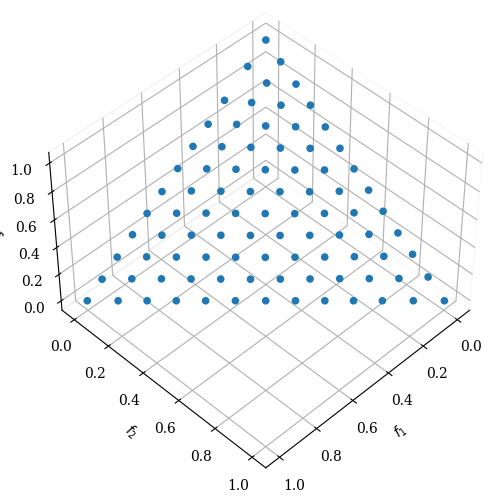

In [15]:
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

ref_dirs = get_reference_directions("energy", 3, 90)

Scatter().add(ref_dirs).show()

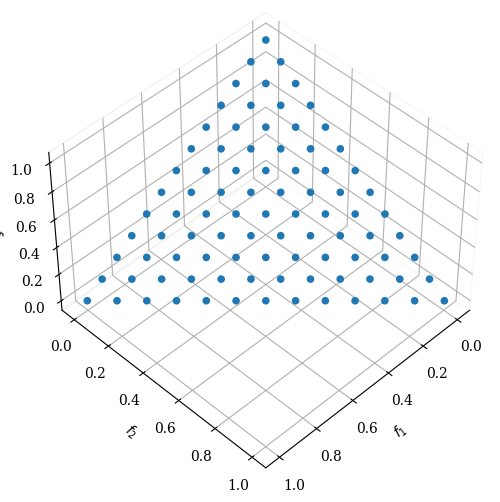

In [16]:
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

ref_dirs = get_reference_directions("uniform", 3, n_partitions=12)
Scatter().add(ref_dirs).show()

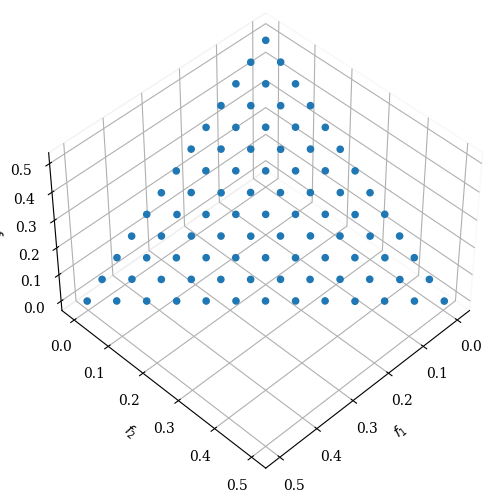

In [17]:
from pymoo.algorithms.moo.nsga3 import NSGA3

from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

# create the algorithm object
algorithm = NSGA3(
  pop_size=92,
  ref_dirs=ref_dirs
)

# execute the optimization
res = minimize(
  get_problem("dtlz1"),
  algorithm,
  termination=('n_gen', 600)
)

Scatter().add(res.F).show()

In [25]:
import numpy as np

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.problems import get_problem
from pymoo.optimize import minimize

problem = get_problem("ackley", n_var=30)

# create the reference directions to be used for the optimization - just a single one here
ref_dirs = np.array([[1.0]])

# create the algorithm object
algorithm = UNSGA3(ref_dirs, pop_size=100)

# execute the optimization
res = minimize(
  problem,
  algorithm,
  termination=('n_gen', 150),
  save_history=True
)

print("UNSGA3: Best Solution found: \nX = %s\nF = %s" % (res.X, res.F))

UNSGA3: Best Solution found: 
X = [-0.04213717 -0.12135215  0.01718334  0.00291512 -0.00764595  0.12355117
  0.05480397  0.0530101  -0.08813807 -0.0108217  -0.06156078 -0.0955661
  0.08871957  0.12814863 -0.03472236  0.03633451  0.24016347  0.04205341
 -0.01237696  0.03670737  0.10847154  0.06491349 -0.03379272 -0.01846142
  0.06437412 -0.045857    0.01370508  0.05812438  0.08537708  0.07847212]
F = [0.60606153]


In [28]:
_res = minimize(
  problem,
  NSGA3(ref_dirs, pop_size=100),
  termination=('n_gen', 150),
  save_history=True,
)

print("NSGA3: Best Solution found: \nX = %s\nF = %s" % (res.X, res.F))

NSGA3: Best Solution found: 
X = [-0.04213717 -0.12135215  0.01718334  0.00291512 -0.00764595  0.12355117
  0.05480397  0.0530101  -0.08813807 -0.0108217  -0.06156078 -0.0955661
  0.08871957  0.12814863 -0.03472236  0.03633451  0.24016347  0.04205341
 -0.01237696  0.03670737  0.10847154  0.06491349 -0.03379272 -0.01846142
  0.06437412 -0.045857    0.01370508  0.05812438  0.08537708  0.07847212]
F = [0.60606153]


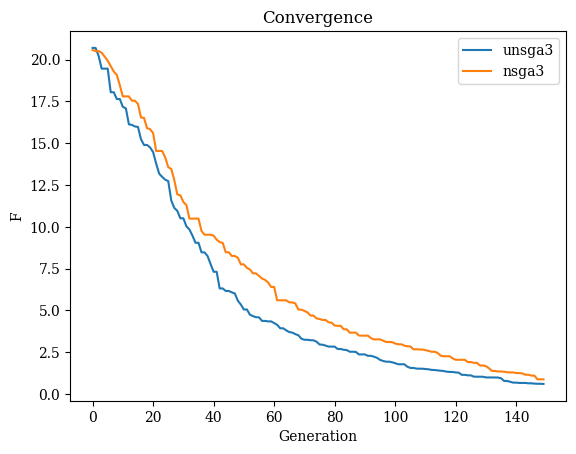

In [29]:
import numpy as np
import matplotlib.pyplot as plt

ret = [np.min(e.pop.get("F")) for e in res.history]
_ret = [np.min(e.pop.get("F")) for e in _res.history]

plt.plot(np.arange(len(ret)), ret, label="unsga3")
plt.plot(np.arange(len(_ret)), _ret, label='nsga3')
plt.title("Convergence")
plt.xlabel("Generation")
plt.ylabel("F")
plt.legend()
plt.show()

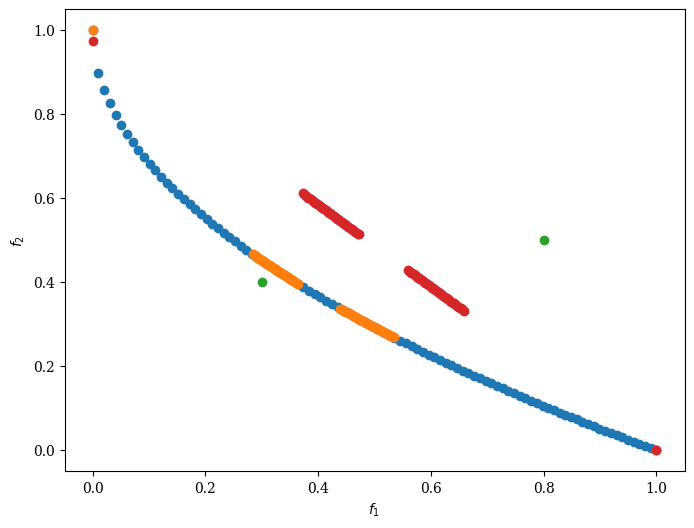

In [31]:
import numpy as np

from pymoo.algorithms.moo.rnsga3 import RNSGA3
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("zdt1")
pf = problem.pareto_front()

# Define reference points
ref_points = np.array([[0.3, 0.4], [0.8, 0.5]])

# Get Algorithm
algorithm = RNSGA3(
  ref_points=ref_points,
  pop_per_ref_point=50,
  mu=0.1
)

res = minimize(
  problem,
  algorithm=algorithm,
  termination=('n_gen', 300),
  pf=pf,
  verbose=False
)

reference_directions = res.algorithm.survival.ref_dirs

plot = Scatter()
plot.add(pf, label="pf")
plot.add(res.F, label="F")
plot.add(ref_points, label="ref_points")
plot.add(reference_directions, label="ref_dirs")
plot.show()

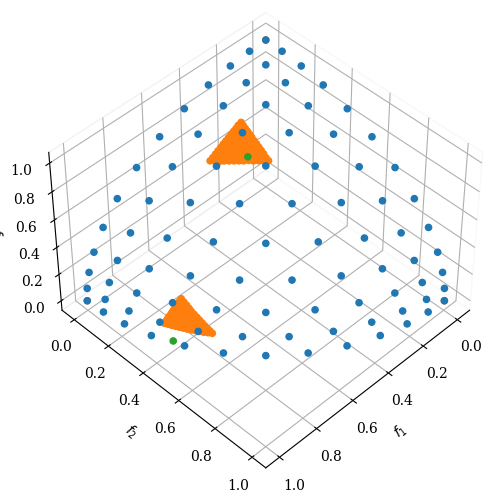

In [32]:
from pymoo.util.reference_direction import UniformReferenceDirectionFactory

# Get problem
problem = get_problem("dtlz4", n_var=12, n_obj=3)

# Define reference points and reference directions
ref_points = np.array([[1.0, 0.5, 0.2], [0.3, 0.2, 0.6]])
ref_dirs = UniformReferenceDirectionFactory(3, n_points=91).do()
pf = problem.pareto_front(ref_dirs)

# Get Algorithm
algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=91,
    mu=0.1)

res = minimize(problem,
               algorithm,
               termination=('n_gen', 300),
               pf=pf,
               seed=1,
               verbose=False)


plot = Scatter()
plot.add(pf, label="pf")
plot.add(res.F, label="F")
plot.add(ref_points, label="ref_points")
plot.show()

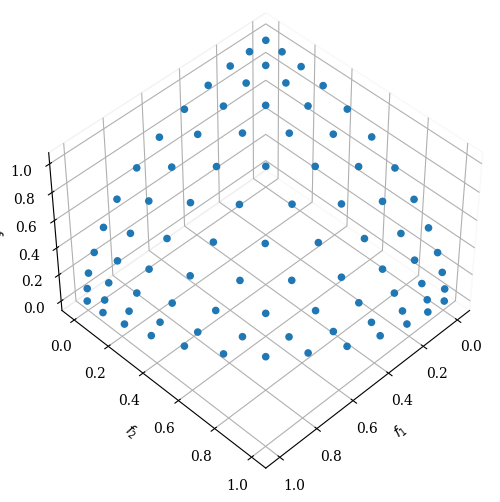

In [34]:
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

problem = get_problem("dtlz2")

ref_dirs = get_reference_directions("uniform", 3, n_partitions=12)

algorithm = MOEAD(
  ref_dirs,
  n_neighbors=15,
  prob_neighbor_mating=0.7
)

res = minimize(
  problem,
  algorithm,
  ('n_gen', 200),
  verbose=False
)

Scatter().add(res.F).show()

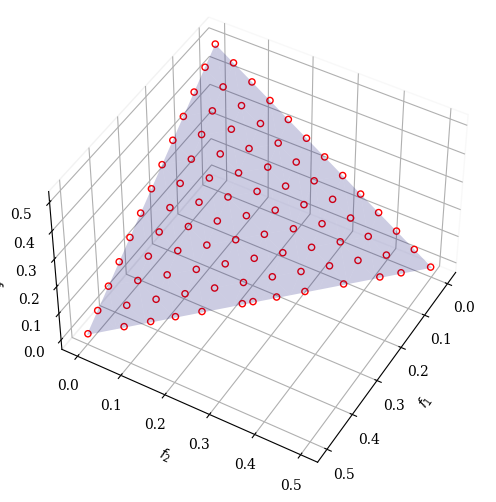

In [35]:
from pymoo.algorithms.moo.ctaea import CTAEA
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("c1dtlz1", None, 3, k=5)

ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

# create the algorithm object
algorithm = CTAEA(ref_dirs=ref_dirs)

# execute the optimization
res = minimize(problem,
               algorithm,
               ('n_gen', 600),
               seed=1,
               verbose=False
               )

sc = Scatter(legend=False, angle=(45, 30))
sc.add(problem.pareto_front(ref_dirs), plot_type='surface', alpha=0.2, label="PF", color="blue")
sc.add(res.F, facecolor="none", edgecolor="red")
sc.show()